In [2]:
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
img_dir = "Stereo_images"
if os.path.exists(img_dir):
    if os.listdir(img_dir) is []:
        print("No images!")
        exit(0)
    num_img = len(os.listdir(img_dir))
    for img in os.listdir(img_dir):
        if not img.endswith("png"):
            continue
        image_dir = os.path.join(img_dir, img)
        image = cv2.imread(image_dir)
        gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        plt.imshow(gray)
        plt.show()
else:
    print("image folder not exists!")
    exit(0)

In [4]:
def getPatches(kps, img, size=32, num=500):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)
        res[i, 0, ymin_res: ymax_res, xmin_res: xmax_res] = img[ymin: ymax, xmin: xmax]
    return res

In [5]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create(600)

In [6]:
img_dir = "Stereo_images/p_image"
kps_num = 50
img_num = 5
patch_size = 32
res_kps = torch.zeros(img_num, kps_num, 2)
res_pts = torch.zeros(img_num, kps_num, 1, patch_size, patch_size)

for idx in range(img_num):
    image_dir = os.path.join(img_dir, "image{}1.png".format(idx+1))
    if not os.path.exists(image_dir):
        print("image {} not exists".format(image_dir))
    image = cv2.imread(image_dir)
    img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    ## find the keypoints and descriptors with SIFT, need to sort based on the response
    kps, des = sift.detectAndCompute(img, None)
    kps.sort(key=lambda x:x.response, reverse=True)
    
    ## remove duplicate
    temp = set()
    kps = [x for x in kps if x.pt not in temp and not temp.add(x.pt)]
    
    keypoints_img = [kps[a].pt for a in range(kps_num)] 
    res_kps[idx] = torch.FloatTensor(keypoints_img)
    
    ## extract patches
    res_pts[idx] = getPatches(keypoints_img, img, size=patch_size, num=kps_num)

In [7]:
res_pts.shape

torch.Size([5, 50, 1, 32, 32])

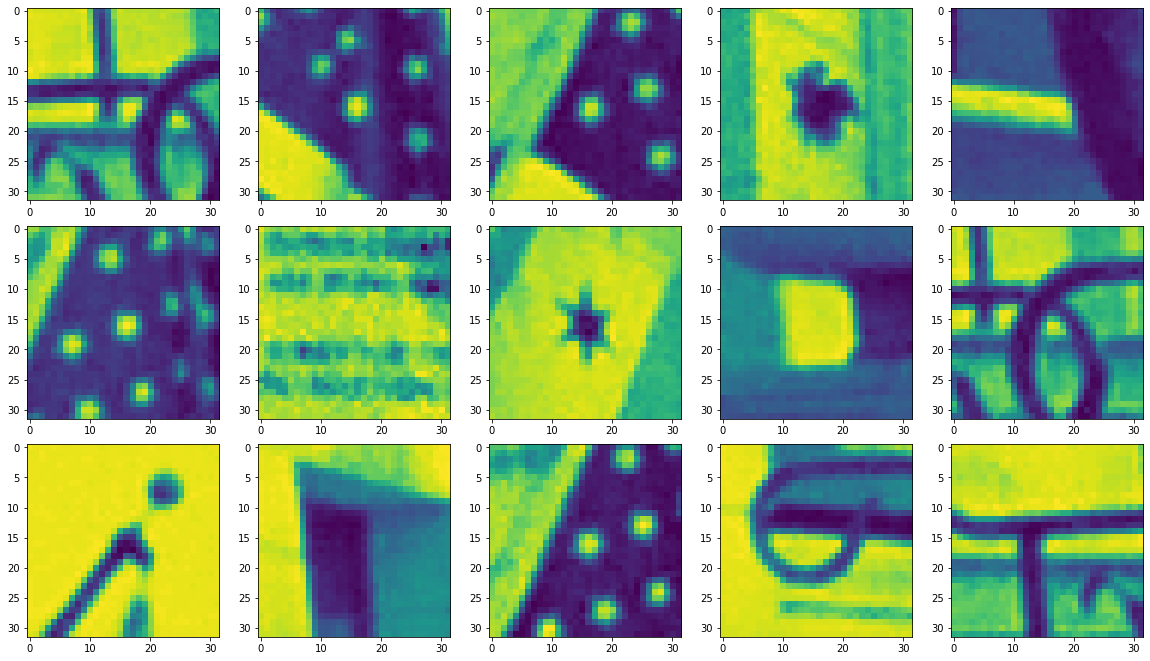

In [28]:
img_id = 4
img = cv2.imread('Stereo_images/p_image/image{}1.png'.format(img_id+1))
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
pts5 = res_pts[img_id]
fig=plt.figure(figsize=(20, 12))
fig.subplots_adjust(hspace=0.01, wspace=0.2)
for idx in range(15):
    im = pts5[idx, 0].numpy()
    fig.add_subplot(3, 5, idx+1)
    plt.imshow(im)
plt.show()

In [29]:
# save patches
print(res_pts.shape)
output_dir = "p_patches.pth"
torch.save(res_pts, output_dir)

# save key points
print(res_kps.shape)
torch.save(res_kps, "p_keypints.pth")

torch.Size([5, 50, 1, 32, 32])
torch.Size([5, 50, 2])


In [26]:
res_kps.shape

torch.Size([5, 50, 2])